## bag of tricks

we've got a few more things we can do to improve things

* our bias terms can start at zero or close to zero
* we can make the output layer weights smaller

* we can now also start increasing our dimensions 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
context_length = 5
embedding_dimensions = 6

In [3]:
%run ../lib/basic_sampling.py

In [4]:
names = NameSampling("../resources/names.txt")
vocab_size = len(names.itos)
names_length = names.names_length

In [5]:
# keep the same values for the experiments
epochs = 120
batch_size = 800
learning_rate = .2
samples = 1000

## Now run the same network

as well as our Kaiming normal distribution we apply the other adjustments to the network

In [6]:
vocab_size = len(names.itos)

es = torch.randn((vocab_size, embedding_dimensions), requires_grad=True)

W1 = torch.randn((embedding_dimensions*context_length, 100)) * 5/3

nn.init.kaiming_normal_(W1, nonlinearity='tanh')

b1 = torch.zeros(100, dtype=torch.float)

W2 = torch.randn((100, 27)) * 0.1

b2 = torch.randn(27) * 0.00001

parameters = [es, W1, b1, W2, b2]


for p in parameters:
    p.requires_grad=True


In [7]:
import matplotlib.pyplot as plt

In [8]:
track = {'weights': [], 'activations': [], 'gradients': [], 'loss': [], 'learning_rate': []}

In [9]:
for ep in range(epochs):
    epoch_loss = 0
    for s in range(samples):
        x, y = names.get_xys(names.sample_names(batch_size))
        X = torch.tensor(x)
        Y = torch.tensor(y)
        train = es[X.view(-1)]
        l_in = train.view(-1, embedding_dimensions * context_length)
        
        outputL1 = torch.tanh(l_in @ W1 + b1)
        
        logits = outputL1 @ W2 + b2
        
        loss = F.cross_entropy(logits, Y)

        epoch_loss += loss

        for p in parameters:
            p.grad = None
        
        loss.backward()

        for p in parameters:
            p.data -= learning_rate * p.grad
        
    learning_rate *= .99

    if ep % 10 == 0:
        track['weights'].append(W1.detach())
        track['activations'].append(outputL1.detach())
        track['gradients'].append(W1.grad.detach())
        
        print(ep, learning_rate)
        print(epoch_loss/samples)

0 0.198
tensor(2.4087, grad_fn=<DivBackward0>)
10 0.17906765085174328
tensor(2.1074, grad_fn=<DivBackward0>)
20 0.16194557364425166
tensor(2.0785, grad_fn=<DivBackward0>)
30 0.14646067393087944
tensor(2.0684, grad_fn=<DivBackward0>)
40 0.13245640819679666
tensor(2.0613, grad_fn=<DivBackward0>)
50 0.1197912012932322
tensor(2.0570, grad_fn=<DivBackward0>)
60 0.10833701519337073
tensor(2.0540, grad_fn=<DivBackward0>)
70 0.097978054600841
tensor(2.0522, grad_fn=<DivBackward0>)
80 0.08860959632523453
tensor(2.0498, grad_fn=<DivBackward0>)
90 0.08013693059030814
tensor(2.0487, grad_fn=<DivBackward0>)
100 0.07247440357209944
tensor(2.0469, grad_fn=<DivBackward0>)
110 0.06554455148756082
tensor(2.0453, grad_fn=<DivBackward0>)


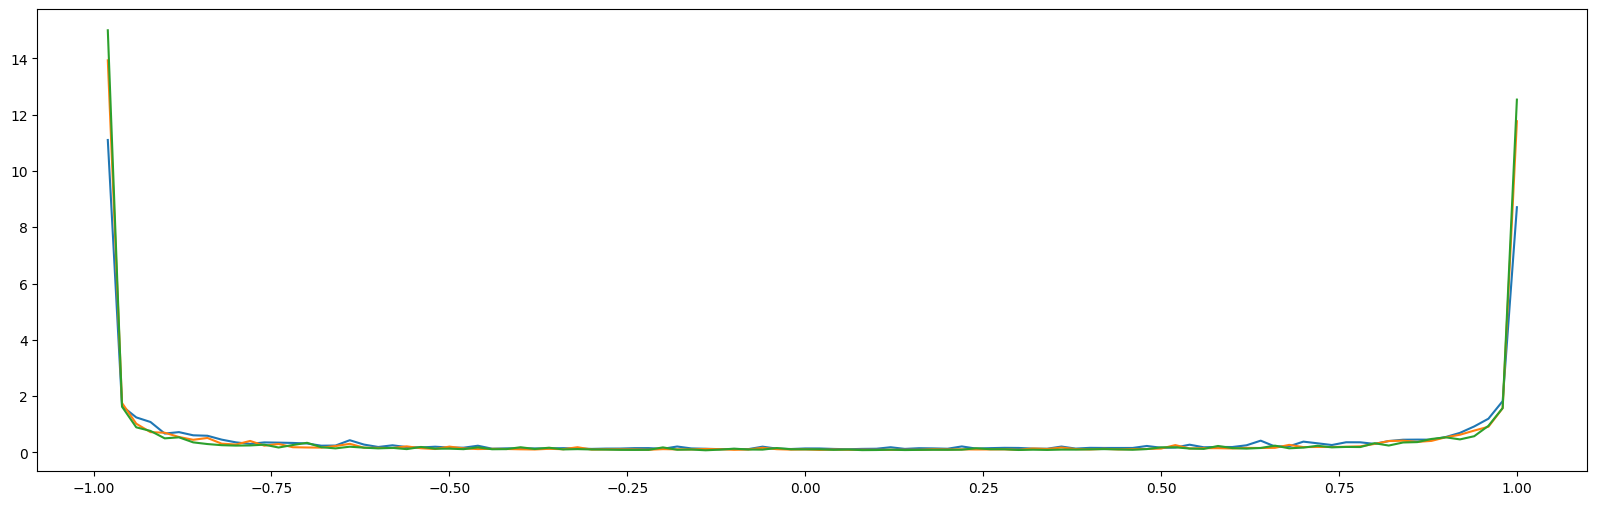

In [10]:
plt.figure(figsize=(20,6))

hy, hx = torch.histogram(track['activations'][1], density=True)
plt.plot(hx.detach()[1:], hy.detach())
hy, hx = torch.histogram(track['activations'][5], density=True)
plt.plot(hx.detach()[1:], hy.detach())
hy, hx = torch.histogram(track['activations'][9], density=True)
plt.plot(hx.detach()[1:], hy.detach())

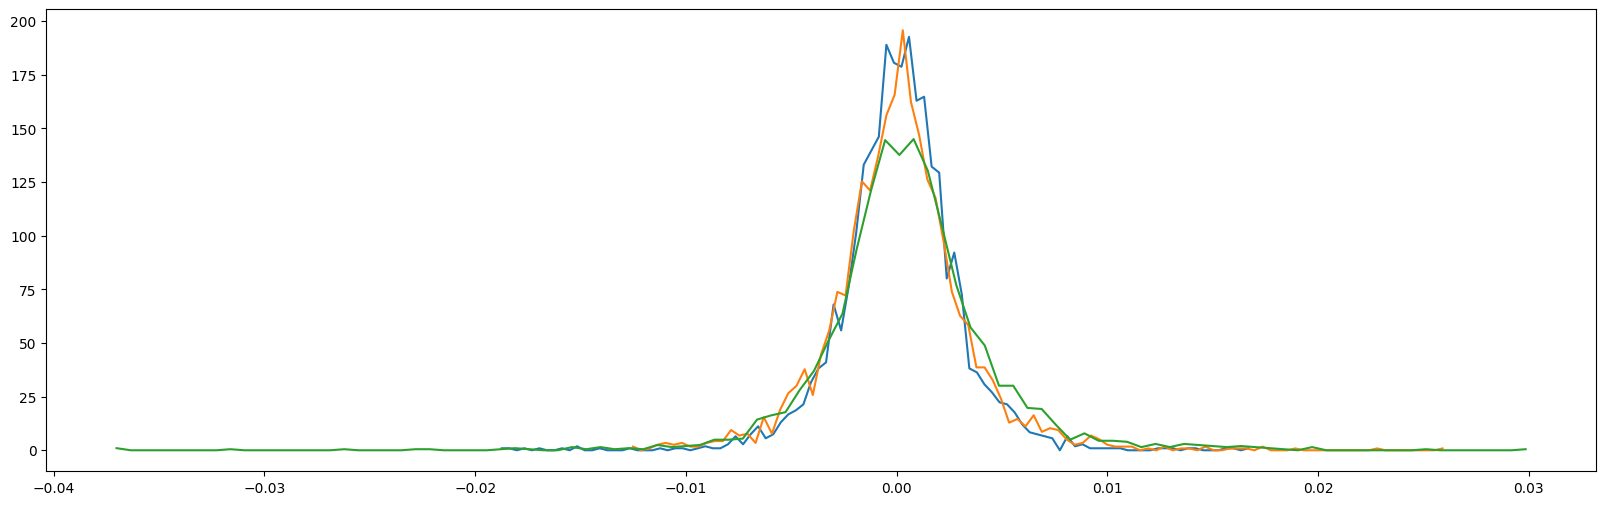

In [11]:
plt.figure(figsize=(20,6))

hy, hx = torch.histogram(track['gradients'][1], density=True)
plt.plot(hx.detach()[1:], hy.detach())
hy, hx = torch.histogram(track['gradients'][5], density=True)
plt.plot(hx.detach()[1:], hy.detach())
hy, hx = torch.histogram(track['gradients'][9], density=True)
plt.plot(hx.detach()[1:], hy.detach())

In [12]:
def generate_names(num_names):
    for i in range(num_names):
        out = []
        ix = [0, 0, 0, 0, 0]
        for nl in range(10):
            xenc = es[ix]

            outputL1 = torch.tanh(xenc.view(-1, embedding_dimensions * context_length) @ W1 + b1)
            
            logits = outputL1 @ W2 + b2
            
            p = F.softmax(logits, dim=1)
    
            prediction = torch.multinomial(p, num_samples=1).item()
            
            ix = [ix[1], ix[2], ix[3], ix[4], prediction]

            if prediction == 0:
                break
            out.append(names.itos[prediction])
            
        print("".join(out))

In [13]:
generate_names(10)

elyga
danuil
cristyn
calaynah
alukzand
elith
abi
aquan
racardley
laleenni


## OK time to start tracking things

we have improving results and stability

so next we'll start looking at the size of the model and alternative non-linearities 

In [15]:
for ep in range(1):
    epoch_loss = 0
    for s in range(1):
        x, y = names.get_xys(names.sample_names(batch_size))
        X = torch.tensor(x)
        Y = torch.tensor(y)

        print(Y.shape, logits.shape)

        break
        
        train = es[X.view(-1)]
        l_in = train.view(-1, embedding_dimensions * context_length)
        
        outputL1 = torch.tanh(l_in @ W1 + b1)
        
        logits = outputL1 @ W2 + b2

        loss = F.cross_entropy(logits, Y)

        epoch_loss += loss

        for p in parameters:
            p.grad = None
        
        loss.backward()

        for p in parameters:
            p.data -= learning_rate * p.grad
        
    learning_rate *= .99

    if ep % 10 == 0:
        track['weights'].append(W1.detach())
        track['activations'].append(outputL1.detach())
        track['gradients'].append(W1.grad.detach())
        
        print(ep, learning_rate)
        print(epoch_loss/samples)

torch.Size([5753]) torch.Size([5753, 27])
0 0.058684544305043274
0.0


In [16]:
x, y = names.get_xys(names.sample_names(batch_size))

torch.tensor(x).shape

torch.Size([5699, 5])